In [29]:
from jax import config
config.update("jax_enable_x64", True)
%load_ext autoreload
%autoreload 2
import time
import numpy as np
import pylab as plt
import jax
import jax.random as jr
from jax.random import PRNGKey
import jax.numpy as jnp

# FLAX library
from flax import linen as nn

# OPTAX for ADAM optimizer
import optax

import sys
sys.path.insert(1, '..')
from kronojax.neural.KAN import KAN, MLP
from kronojax.neural.embedding import time_embedding
# set the matplotlib theme
# import kronojax.plotting.matplotlib_theme

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [30]:
# initialize the random number generator
key = jr.PRNGKey(0)

#### Definition of a target distribution to sample from

In [31]:
def log_target(x):
    """ Mixture of two Gaussians """
    mu1 = -1.
    mu2 = 1.
    sigma = 0.3
    proba_1 = jnp.exp(-0.5*(x-mu1)**2 / sigma**2)
    proba_2 = jnp.exp(-0.5*(x-mu2)**2 / sigma**2)
    return jnp.log(0.5 * proba_1 + 0.5 * proba_2)

log_target_batch = jax.vmap(log_target)
grad_log_target = jax.grad(log_target)
grad_log_target_batch = jax.vmap(grad_log_target)

#### parametrize a drift with a neural net

In [32]:
class NN_drift(nn.Module):
    """
    A neural network that parametrizes the drift drift(x, t)
      drift: R^D x R -> R^D
    """
    time_embedding_dim: int     # dimension of the time embedding
    time_freq_min: float        # minimum frequency of the time embedding     
    time_freq_max: float        # maximum frequency of the time embedding
    dim_list: list              # list of dimensions of the hidden layers
    
    @nn.compact
    def __call__(self, x, t):
        # can use a basic MLP or a KAN architecture
        REGRESSOR = "KAN"
        assert REGRESSOR in ["KAN", "MLP"]
        
        # compute time embedding $ concat x and t
        t_embedded = time_embedding(t, self.time_freq_min, self.time_freq_max, self.time_embedding_dim)
        input_ = jnp.concatenate([x, t_embedded], axis=1)

        # create the regressor
        if REGRESSOR == "KAN":
            regressor = KAN(dim_list=self.dim_list, degree=4)
        elif REGRESSOR == "MLP":
            regressor = MLP(dim_list=self.dim_list)
        else:
            # raise an error as type of regressor is not recognized
            raise ValueError("Regressor type not recognized")
        
        return regressor(input_)

In [33]:
# create the neural net that parametrizes the drift(x, t)
key, key_ = jr.split(key)
time_embedding_dim = 16
time_freq_min = 1.
time_freq_max = 10
output_dim = 1
dim_list = [20, 20, output_dim]
net = NN_drift(time_embedding_dim, time_freq_min, time_freq_max, dim_list)

# create a dummy input to initialize the network
batch_sz = 32
key, key_ = jr.split(key)
xs = jr.normal(key_, (batch_sz, 1))
ts = jr.uniform(key_, (batch_sz, 1))
params = net.init(key_, xs, ts)

In [ ]:
# print(params)

In [20]:
print(params['params']['KAN_0']['ChebyKANLayer_0']['cheby_coeffs'].shape)
print(params['params']['KAN_0']['LayerNorm_0']['scale'].shape)
print(params['params']['KAN_0']['LayerNorm_0']['bias'].shape)

print(params['params']['KAN_0']['ChebyKANLayer_1']['cheby_coeffs'].shape)
print(params['params']['KAN_0']['LayerNorm_1']['scale'].shape)
print(params['params']['KAN_0']['LayerNorm_1']['bias'].shape)

print(params['params']['KAN_0']['ChebyKANLayer_2']['cheby_coeffs'].shape)


(17, 20, 5)
(20,)
(20,)
(20, 20, 5)
(20,)
(20,)
(20, 1, 5)


In [ ]:
print(params['params']['MLP_0']['Dense_0']['kernel'].shape)
print(params['params']['MLP_0']['Dense_0']['bias'].shape)
print(params['params']['MLP_0']['Dense_1']['kernel'].shape)
print(params['params']['MLP_0']['Dense_1']['bias'].shape)
print(params['params']['MLP_0']['Dense_2']['kernel'].shape)
print(params['params']['MLP_0']['Dense_2']['bias'].shape)

In [21]:
# compute the total number of parameters with jax.tree_util.tree_leaves
n_params = sum([p.size for p in jax.tree_util.tree_leaves(params)])
print(f"Number of parameters: {n_params:,}")

Number of parameters: 3,880


In [22]:
# do a 3D plot of the drift for time in [0,1]
Nt , Nx = 100, 100
t_arr = jnp.linspace(0, 1, Nt)
x_arr = jnp.linspace(-1, 1, Nx)
X, T = jnp.meshgrid(x_arr, t_arr)
print(X.shape)
X = X.reshape(-1,1)
T = T.reshape(-1,1)
Y = net.apply(params, X, T)
Y = Y.reshape(Nt, Nx)
print(Y)

(100, 100)
[[0.73970055 0.74418692 0.74693418 ... 1.08087321 1.06026453 1.03880454]
 [0.69525792 0.69613835 0.69623418 ... 1.29080925 1.27598175 1.25952652]
 [0.74705215 0.74833697 0.74953723 ... 1.35589217 1.34927607 1.3412364 ]
 ...
 [0.17079003 0.1499925  0.12954011 ... 1.16979382 1.15969613 1.14916373]
 [0.29564206 0.28121377 0.26636172 ... 1.15578352 1.14397634 1.13133732]
 [0.33389925 0.32424247 0.31358927 ... 1.07659455 1.06377729 1.05006519]]


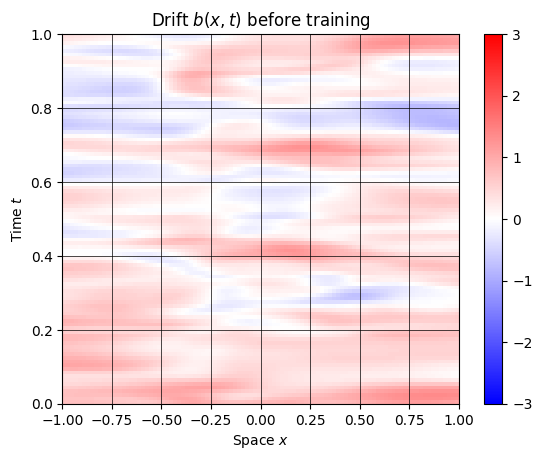

In [23]:
plt.figure()
# set the max/min color to -2 and 2
plt.imshow(Y, extent=[-1, 1, 0, 1], origin='lower', 
           aspect='auto', cmap='bwr', vmin=-3, vmax=3)
plt.grid(True, lw=0.5, color='black')
plt.xlabel(r'Space $x$')
plt.ylabel(r'Time $t$')
plt.title(r'Drift $b(x,t)$ before training')
# colorbar
plt.colorbar()

#### PIS loss function

In [24]:
def integrate(
        params: any,    # parameters of the drift neural network
        N_steps: int,   # number of discretization steps
        batch_sz: int,  # batch size
        key: PRNGKey,   # random key
        ):
    """
    Integrate the SDE:
      dX = u(X,t) dt + dW
    starting from X0 = 0 using the Euler-Maruyama scheme.
    While integrating, compute the integrated cost:
        -(1/2) * \int_0^T u(X,t)^2 dt
        
    returns:
    =======
    dict: {
        "t": jnp.array,                 # time array
        "x": jnp.array,                 # position array
        "integrated_cost": jnp.array,   # integrated cost
    """
    T_final = 1.
    dt = T_final / N_steps
    sqt = jnp.sqrt(dt)

    def _step(carry, _):
        xs, t, integrated_cost, stoch_integ, key = carry
        key, key_ = jr.split(key)
        # Brownian increment
        dw = sqt * jr.normal(key_, xs.shape)
        # create a batch of times
        ts = jnp.ones_like(xs) * t
        # compute the drift
        us = net.apply(params, xs,ts)
        # update the integrated cost
        #integrated_cost = integrated_cost - 0.5 * jnp.mean(us**2) * dt
        integrated_cost = integrated_cost - 0.5 * jnp.sum(us**2, axis=-1) * dt
        # stochastic part
        stoch_integ = stoch_integ - jnp.sum(us * dw, axis=-1)
        xs = xs + us * dt + dw
        t = t + dt
        output_dict = {
            "t": t,
            "x": xs,
            "stoch_integ": stoch_integ,
            "integrated_cost": integrated_cost,
            }
        return (xs, t, integrated_cost,  stoch_integ, key), output_dict
    key, key_ = jr.split(key)
    t_init = 0.
    xs_init = jnp.zeros((batch_sz, 1))
    integrated_cost = jnp.zeros(batch_sz)
    stoch_integ = jnp.zeros(batch_sz)
    carry_init = (xs_init, t_init, integrated_cost, stoch_integ, key_)
    _, sde_traj = jax.lax.scan(_step, carry_init, xs = None, length=N_steps)
    return sde_traj

# compile the function
# integrate = jax.jit(integrate, static_argnums=(1,2,))

<>:7: SyntaxWarning: invalid escape sequence '\i'
<>:7: SyntaxWarning: invalid escape sequence '\i'
C:\Users\wurui\AppData\Local\Temp\ipykernel_19740\3630389026.py:7: SyntaxWarning: invalid escape sequence '\i'
  """


In [25]:
def lof_gauss_ref(x):
    """ Log of the reference Gaussian:
    it is the marginal of the uncontrolled process
    """
    mu = 0.
    sigma = 1.
    return -0.5*(x-mu)**2 / sigma**2

def final_reward(x):
    """ final PIS reward = log[ targte(x) / pi_ref(x) ]
    """
    return log_target(x) - lof_gauss_ref(x)

final_reward_batch = jax.vmap(final_reward)

def loss(
        params: any,    # parameters of the neural network
        N_steps: int,   # number of discretization steps
        batch_sz: int,  # batch size
        key: PRNGKey,   # random key
        ):
    # integral controlled diffusion
    sde_traj = integrate(params, N_steps, batch_sz, key)
    # extract final position and integrated cost
    xs_terminal = sde_traj["x"][-1]
    sde_traj["integrated_cost"][-1]
    # compute the PIS cost: (integrated cost) + (final reward)
    final_cost = sde_traj["integrated_cost"][-1] + \
        final_reward_batch(xs_terminal)
        # sde_traj["stoch_integ"][-1] + \
    log_p_over_q = -jnp.mean(final_cost)
    return log_p_over_q

loss = jax.jit(loss, static_argnums=(1,2,))
loss_value_grad = jax.value_and_grad(loss)

In [26]:
N_steps = 100
batch_sz = 100
key, key_ = jr.split(key)
L = loss(params, N_steps, batch_sz, key_)
print(f"Initial loss: {L:.2f}")

Initial loss: 2.47


#### Optimization of the PIS loss

In [27]:
# create ADAM optimizer
LR = 1e-3
optimizer = optax.adam(learning_rate=LR)

# initialize with the parameters
opt_state = optimizer.init(params)

# create the jitted update function
def update(params, opt_state, N_steps, batch_sz, key):
    loss_value, grads = loss_value_grad(params, N_steps, batch_sz, key)
    updates, opt_state = optimizer.update(grads, opt_state)
    new_params = optax.apply_updates(params, updates)
    return new_params, opt_state, loss_value

update = jax.jit(update, static_argnums=(2,3,))

In [28]:
N_ITER = 1_000
BATCH_SZ = 512

# track the loss over each epoch
losses = []
params_history = []

LR = 10**-2
optimizer = optax.adam(learning_rate=LR)

time_start = time.time()
for it in range(N_ITER):
    key, key_ = jr.split(key)
    params, opt_state, loss_value = update(params, opt_state, N_steps, BATCH_SZ, key_)
    losses.append(loss_value)
    # append a deep copy of the jax pytree params for later plotting
    params_history.append(jax.tree.map(lambda x: x.copy(), params))
    # print epoch and average loss
    if it % (N_ITER//10) == 0:
        time_current = time.time()
        print(f"Iteration {it:4d}/{N_ITER}  |  Loss: {loss_value:.2f}  |  Time: {time_current - time_start:.2f} s")

Iteration    0/1000  |  Loss: 2.22  |  Time: 3.11 s
Iteration  100/1000  |  Loss: 1.22  |  Time: 91.39 s
Iteration  200/1000  |  Loss: 1.41  |  Time: 174.11 s
Iteration  300/1000  |  Loss: 1.22  |  Time: 256.57 s
Iteration  400/1000  |  Loss: 1.52  |  Time: 341.73 s
Iteration  500/1000  |  Loss: 1.33  |  Time: 428.80 s
Iteration  600/1000  |  Loss: 1.40  |  Time: 517.72 s
Iteration  700/1000  |  Loss: 1.36  |  Time: 610.59 s
Iteration  800/1000  |  Loss: 1.32  |  Time: 713.73 s
Iteration  900/1000  |  Loss: 1.38  |  Time: 805.75 s
